In [2]:
# Computer Vision:
# 1. CNNs are commonly used for image classification tasks (as they can capture spatial hierarchies and handle larger parameter spaces)
# 2. Image is one moment in time statically, while video is a sequence of images over time
# 3. Today, CNNs can be combined with Transformers to improve performance, e.g. determine distance betweem obj based on overlap layers
# 4. GANs (Generative Adversarial Networks) are used for generating realistic images

In [14]:
# for dealing with file paths and corrupted images since it's a real world dataset
import os 
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import models, layers, utils
from tensorflow.keras.models import Sequential
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# above is the old API, now replaced with image_dataset_from_directory
from tensorflow.keras.utils import image_dataset_from_directory

'''
IMPORTANT: CNNs have neurons, but only after Flatten layer
ANN and LSTM: numbers usually refer to neurons / hidden units
CNN: numbers refer to filters (NOT neurons)
Hence, we increase the number of filters in Conv2D layers to learn richer features -> capture more complex patterns/layers of images
while using MaxPooling to gradually reduce the spatial dimensions (height and width).
After feature extraction, the network transitions to Dense layers for final classification.
Rescaling layer is used to normalize pixel values from [0, 255] to [0, 1] to improve training stability and convergence.
'''
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.callbacks import EarlyStopping

## Data Engineering Phase:
- Please run the codes below once and move the folder created manually to other directory to be archived

In [3]:
# Remove corrupted images from analysis
bad_files = []

# read_csv/excel from pandas, read_file and decode_jpeg from tf.io
for folder in ['Cat', 'Dog']:
    path = f'PetImages/{folder}' # usually its just '' but f'' allows us to insert variable of folder path into the created filename
    for file in os.listdir(path):
        if file.lower() == 'thumbs.db': # Skip Windows system files
            bad_files.append(os.path.join(path, file))
            continue
        try:
            tf.io.decode_jpeg(tf.io.read_file(os.path.join(path, file)))
        except Exception as e: # exception is the base class for most runtime errors in Python
            bad_files.append(os.path.join(path, file))
# Run this once to check if errors occurred

print(f'Found {len(bad_files)} corrupted images')

bad_dir = 'PetImages/bad_images'
# Create folder directory for archive corrupt image
os.makedirs(bad_dir, exist_ok=True)

# Rename them to technically move them to another directory
for file in bad_files:
    base = os.path.basename(file)
    class_name = os.path.basename(os.path.dirname(file))

    # Prevent overwrite
    new_name = f"{class_name}_{base}"
    dst = os.path.join(bad_dir, new_name)

    shutil.move(file, dst) # better handling edge cases than os.rename into new directory as moving them

# Note: Debugging from Data Engineering phase, model error occurred below doesnt arise from DL modelling phase

Found 178 corrupted images


In [15]:
# To design production-grade ML pipelines, GPU and OpenCV preferred over CPU and tf for image/video processing & real-time systems
# Since CPU is used here, simple parameters are chosen to avoid long training times and overfitting risks (understand data & model 1st)
image_size = (128, 128) # height, width
batch_size = 32 # batch processing for faster extraction and production-grade pipelines

# Pull in image from local directory using TensorFlow API
training = image_dataset_from_directory(
    'PetImages',
    validation_split=0.2,
    subset='training', # indicate training set hence 80% of data
    seed=42,
    image_size=image_size, # resize all images to same size
    batch_size=batch_size,
    label_mode='binary' # auto assign labels based on folder names (Cat=0, Dog=1)
)

validation = image_dataset_from_directory(
    'PetImages',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)
# Intuition: load image data from a directory structured by class labels (Dog & Cat), automatically infer labels from subfolder names
# then split/partition data into training and test using validation_split while maintaining class balance across Cat and Dog images
# print(train)

Found 24824 files belonging to 2 classes.
Using 19860 files for training.
Found 24824 files belonging to 2 classes.
Using 4964 files for validation.


In [16]:
# Full Pipeline Model: Disk → Decode → Normalize → Cache → Shuffle → Prefetch → Model

# Rescaling image pixel values from [0,255] (as image loaded as uint8 by default) to [0,1] to train DL faster using small inputs
normalization = Rescaling(1./255)

train = training.map(lambda x, y: (normalization(x), y))
test = validation.map(lambda x, y: (normalization(x), y))
# In production, normalization is done in the model to avoid mismatch at inference 
# but this approach is perfect for learning and experimentation.

# Cache dataset for parallel computing (This is one of the biggest performance wins in TF)
autotune = tf.data.AUTOTUNE # allow tf automatically choose no of parallel threads and prefetch buffer size

train = train.cache().shuffle(1000).prefetch(autotune) # Shuffle prevents model from learning order bias
test = test.cache().prefetch(autotune) # Validation must remain deterministic

# Cache stores the dataset in memory (RAM) after first pass and subsequent epochs reuse cached data
# Loads next batch while current batch is training which Overlaps Data loading and Model execution
# Disk I/O happens once so Training becomes CPU-bound instead of I/O-bound

In [17]:
# Build CNN from scratch (Note: Ns stands for Neurons)
model = Sequential([ # Standard prac: kernel size = (3,3) & padding same indicates preserve the spatial dimensionality
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2,2)), # pool size = (2,2) -> take 2 pixels per iteration and then halve it to next layer

    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
]) # Intuition: input (H=128, W=128, Channel=3) -> Channel=32 & Pooled (128/2=64) -> 64 & 32 -> 128 & 16, So 128*16^2 map into 128 Ns

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model on data/image
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(train, validation_data=test, epochs=10, callbacks=[early_stop])

# Insights: Stop at Epoch 6 where train_accuracy = 93% & val_accuracy = 0.82

Epoch 1/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 164s 193ms/step - accuracy: 0.5845 - loss: 0.6770 - val_accuracy: 0.7143 - val_loss: 0.5589
Epoch 2/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.7456 - loss: 0.5101 - val_accuracy: 0.7730 - val_loss: 0.4772
Epoch 3/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 92s 148ms/step - accuracy: 0.8139 - loss: 0.4069 - val_accuracy: 0.8060 - val_loss: 0.4225
Epoch 4/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 92s 148ms/step - accuracy: 0.8526 - loss: 0.3414 - val_accuracy: 0.8120 - val_loss: 0.4183
Epoch 5/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 137s 220ms/step - accuracy: 0.8899 - loss: 0.2625 - val_accuracy: 0.8274 - val_loss: 0.4209
Epoch 6/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 105s 169ms/step - accuracy: 0.9317 - loss: 0.1700 - val_accuracy: 0.8157 - val_loss: 0.5001


156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8111 - loss: 0.4105
Test Accuracy: 0.8120467662811279


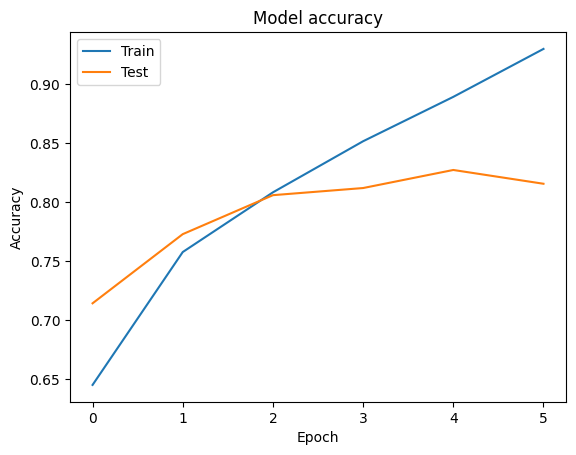

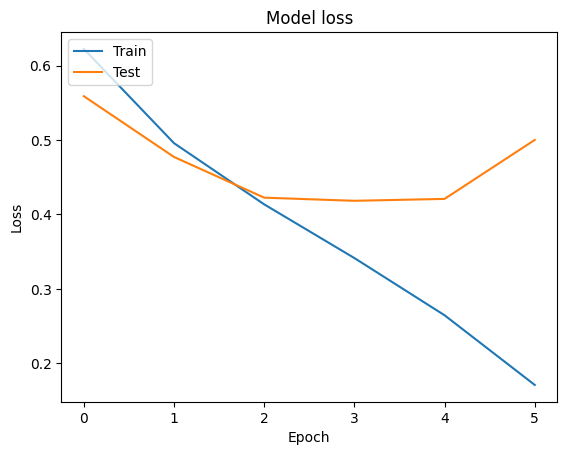

In [ ]:
loss, accuracy = model.evaluate(test)

# Evaluate model
# loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy}')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Conclusion: Although accuracy only supporting evidence, manage to predict moderately & consistently on image due to early_stop
# However, model loss increases on future data hence overfitting risk was spotted (Test loss: 0.5 & Final Test accuracy: 0.81)

In [ ]:
# def preprocess(data):
#     # Remove corrupted images
#     def filter_corrupted(image, label):
#         return tf.reduce_all(tf.image.is_finite(image))
    
#     data = data.filter(filter_corrupted)
#     # Rescale pixel values from [0, 255] to [0, 1]
#     data = data.map(lambda x, y: (x / 255.0, y))
#     # Cache datasets for performance
#     data = data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#     return data